### Imports

In [1]:
import pandas as pd
from collections import defaultdict
import requests
from typing import List
import re
import os
import io
import numpy as np

import glob
import csv

pd.set_option('display.max_columns', 500)

## Installation and Downloads
Sources for data is found within the README.md.

This code should be put into the scripts and into an ETL object.

## Getting our Balance Data

In [18]:
def check_columns(dataframes: pd.DataFrame) -> List[pd.DataFrame]:
    col_hash = defaultdict(list)
    for df in dataframes:
        col_len = len(df.columns)
        col_hash[col_len].append(df)
    max_col = max(col_hash.keys())
    while len(col_hash) > 1:
        min_col = min(col_hash.keys())
        cols = set(col_hash[max_col][0].columns)
        cur_df = col_hash[min_col].pop()
        cur_cols = cur_df.columns
        diff = list(cols.difference(cur_cols))
        cur_df[diff] = np.nan
        col_hash[max_col].append(cur_df)
        if len(col_hash[min_col]) == 0:
            del col_hash[min_col]
    return col_hash[max_col]

In [24]:
def extract_csvs(start: int, end: int) -> List[pd.DataFrame]:
    dfs = []
    for year in range(start, end+1):
        firsthalf_link = f"https://www.eia.gov/electricity/gridmonitor/sixMonthFiles/EIA930_BALANCE_{year}_Jan_Jun.csv"
        sechalf_link = f"https://www.eia.gov/electricity/gridmonitor/sixMonthFiles/EIA930_BALANCE_{year}_Jul_Dec.csv"
        
        r1 = requests.get(firsthalf_link)
        r2 = requests.get(sechalf_link)
        try:
            data1 = r1.content.decode('utf8')
            data2 = r2.content.decode('utf8')
            d1 = pd.read_csv(io.StringIO(data1), low_memory=False)
            d2 = pd.read_csv(io.StringIO(data2), low_memory=False)
            df = pd.concat([d1, d2], axis=0)
        
            cols = [col for col in df.columns if "Imputed" not in col and "Adjusted" in col]
            columns = list(df.columns[:4]) + cols + ["Region"]
            # midw = df[(df['Region'] == "MIDW") & (df['Balancing Authority'] == "MISO")][columns]
            # dfs.append(midw)
            dfs.append(df[columns])
        except Exception as e:
            print(e)
    return dfs

In [25]:
def balance_sheets() -> None:
    threshold = 0.8
    pattern = r'\([^()]*\)|\b(from|at|of)\b'
    dfs = extract_csvs(2016, 2024)
    dfs = check_columns(dfs)
    master_df = pd.concat(dfs, axis=0, ignore_index=True)
    master_df.columns = ["_".join(re.sub(pattern, '', col).lower().split()) for col in master_df.columns]
    master_df["local_time_end_hour"] = pd.to_datetime(master_df["local_time_end_hour"])
    master_df =  master_df \
        .sort_values("local_time_end_hour",  ignore_index=True) \
        .dropna(axis=1, thresh=int(len(master_df) * (1-0.7))) \
        .dropna(axis=0, thresh=7) \
        .bfill(axis=0)
    master_df.to_csv("../../data/balance_sheet.csv", index=False)

In [26]:
balance_sheets()
pd.read_csv("../../data/balance_sheet.csv")

Index(['balancing_authority', 'data_date', 'hour_number',
       'local_time_end_hour', 'demand', 'net_generation', 'total_interchange',
       'net_generation_coal', 'net_generation_natural_gas',
       'net_generation_nuclear', 'net_generation_all_petroleum_products',
       'net_generation_hydropower_and_pumped_storage', 'net_generation_solar',
       'net_generation_wind', 'net_generation_other_fuel_sources', 'region'],
      dtype='object')


/tmp/ipykernel_264662/3087034547.py:2: DtypeWarning: Columns (7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  pd.read_csv("../../data/balance_sheet.csv")


,balancing_authority,data_date,hour_number,local_time_end_hour,demand,net_generation,total_interchange,net_generation_coal,net_generation_natural_gas,net_generation_hydropower_and_pumped_storage,net_generation_solar,net_generation_wind,net_generation_other_fuel_sources,region
0,DOPD,01/01/2016,1,2016-01-01 01:00:00,275,485,210,0,0,0,0,0,0,NW
1,PSCO,01/01/2016,1,2016-01-01 01:00:00,"5,069","4,302",-767,0,0,0,0,0,0,NW
2,GRMA,01/01/2016,1,2016-01-01 01:00:00,"1,849",709,709,0,0,0,0,0,0,SW
3,WWA,01/01/2016,1,2016-01-01 01:00:00,"1,849",72,72,0,0,0,0,0,0,NW
4,BANC,01/01/2016,1,2016-01-01 01:00:00,"1,849","1,271",-578,0,0,0,0,0,0,CAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4890779,TPWR,09/30/2024,24,2024-10-01 00:00:00,397,156,-241,"6,712","8,265",156,21,"13,987",32,NW
4890780,SWPP,09/30/2024,24,2024-10-01 00:00:00,"30,196","31,243","1,036","6,712","8,265",921,21,"13,987",32,CENT
4890781,SEPA,09/30/2024,24,2024-10-01 00:00:00,"14,765",100,96,0,"7,318",100,0,348,"2,921",SE
4890782,NYIS,09/30/2024,24,2024-10-01 00:00:00,"14,765","12,558","-2,207",0,"7,318","1,969",0,348,"2,921",NY


In [27]:
df = pd.read_csv("../../data/balance_sheet.csv")

/tmp/ipykernel_264662/2251799090.py:1: DtypeWarning: Columns (7,8,9,10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../../data/balance_sheet.csv")


In [30]:
df[df['region'] == "MIDW"]['balancing_authority'].unique()

array(['MISO', 'AECI', 'EEI', 'LGEE', 'GLHB'], dtype=object)

## Can we get tar and Untar Data in one Go?
Probably not, I think it's faster if you download the data from the site and untar it manually. Put that into the data folder and this should handle the rest.

### DLY Convert

In [89]:
fields = [
    ["ID", 1, 11],
    ["YEAR", 12, 15],
    ["MONTH", 16, 17],
    ["ELEMENT", 18, 21]
]

offset = 22

for value in range(1, 32):
    fields.append((f"VALUE{value}", offset,     offset + 4))
    fields.append((f"MFLAG{value}", offset + 5, offset + 5))
    fields.append((f"QFLAG{value}", offset + 6, offset + 6))
    fields.append((f"SFLAG{value}", offset + 7, offset + 7))
    offset += 8

# Modify fields to use Python numbering
fields = [[var, start - 1, end] for var, start, end in fields]
fieldnames = [var for var, start, end in fields]


In [91]:
for dly_filename in glob.glob(r'../../data/ghcnd_hcn/*.dly', recursive=True): 
    path, name = os.path.split(dly_filename)
    csv_filename = os.path.join(path, f"{os.path.splitext(name)[0]}.csv")

    with open(dly_filename, newline='') as f_dly, open(csv_filename, 'w', newline='') as f_csv:
        csvout = csv.writer(f_csv)
        csvout.writerow(fieldnames)    # Write a header using the var names

        for line in f_dly:
            row = [line[start:end].strip() for var, start, end in fields]
            csvout.writerow(row)

In [ ]:
def dly_convert() -> None:
    fields = [
        ["ID", 1, 11],
        ["YEAR", 12, 15],
        ["MONTH", 16, 17],
        ["ELEMENT", 18, 21]
    ]
    
    offset = 22
    
    for value in range(1, 32):
        fields.append((f"VALUE{value}", offset,     offset + 4))
        fields.append((f"MFLAG{value}", offset + 5, offset + 5))
        fields.append((f"QFLAG{value}", offset + 6, offset + 6))
        fields.append((f"SFLAG{value}", offset + 7, offset + 7))
        offset += 8
    
    # Modify fields to use Python numbering
    fields = [[var, start - 1, end] for var, start, end in fields]
    fieldnames = [var for var, start, end in fields]
    for dly_filename in glob.glob(r'../../data/ghcnd_hcn/*.dly', recursive=True): 
        path, name = os.path.split(dly_filename)
        csv_filename = os.path.join(path, f"{os.path.splitext(name)[0]}.csv")
    
        with open(dly_filename, newline='') as f_dly, open(csv_filename, 'w', newline='') as f_csv:
            csvout = csv.writer(f_csv)
            csvout.writerow(fieldnames)    # Write a header using the var names
    
            for line in f_dly:
                row = [line[start:end].strip() for var, start, end in fields]
                csvout.writerow(row)

### Get CSV

In [23]:
def get_station_df(file) -> pd.DataFrame:
    station_df = pd.read_fwf(
        file,
        header=None,
        names=["ID", "lat", "long", "elev", "city", "unk1", "unk2", "unk3"],
    )

    return station_df

station_df = get_station_df("../../data/ghcnd-stations.txt")

In [24]:
import geopandas as gpd
from shapely.geometry import Point

In [25]:
gdf = gpd.read_file("../../data/miso.geojson")

<Axes: >

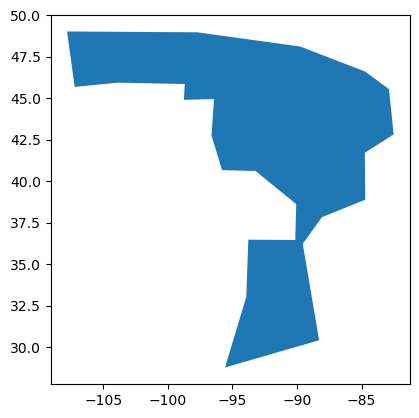

In [26]:
gdf.plot()

In [39]:
gdf.contains(Point(-90, 33))

0    True
dtype: bool

In [34]:
points = pd.Series([Point(x, y) for x, y in zip(station_df.long, station_df.lat)])

In [40]:
def in_miso(row):
    point = Point(row.long, row.lat)
    return gdf.contains(point).any()

In [42]:
truth = station_df.apply(in_miso, axis=1)

In [43]:
truth[truth]

28429     True
28536     True
28537     True
28616     True
28617     True
          ... 
127170    True
127172    True
127173    True
127174    True
127175    True
Length: 13216, dtype: bool

In [44]:
station_df[truth]

,ID,lat,long,elev,city,unk1,unk2,unk3
28429,CA006022010,48.5167,-93.7500,335.0,DEVLIN,NaN,NaN,NaN
28536,CA006045676,48.1000,-89.8833,350.0,NOLALU SSW22,NaN,NaN,NaN
28537,CA006045711,48.1333,-90.5667,479.0,NORTH LAKE,NaN,NaN,NaN
28616,CA006057591,46.4833,-84.5167,192.0,SAULT STE MARIE A,NaN,NaN,71260.0
28617,CA006057592,46.4833,-84.5167,192.0,SAULT STE MARIE A,NaN,NaN,71260.0
...,...,...,...,...,...,...,...,...
127170,USW00094989,41.9906,-93.6186,281.3,AMES MUNI AP,NaN,NaN,NaN
127172,USW00094991,40.6306,-93.9006,345.6,LAMONI MUNI AP,NaN,NaN,NaN
127173,USW00094992,47.7453,-90.3456,185.0,GRAND MARAIS,NaN,NaN,NaN
127174,USW00094993,45.6689,-96.9919,353.0,SISSETON MUNI AP,NaN,NaN,NaN


In [28]:
from shapely.geometry import Point, Polygon
import geopandas

polys = geopandas.GeoSeries({
    'foo': Polygon([(5, 5), (5, 13), (13, 13), (13, 5)]),
    'bar': Polygon([(10, 10), (10, 15), (15, 15), (15, 10)]),
})

_pnts = [Point(3, 3), Point(8, 8), Point(11, 11)]
pnts = geopandas.GeoDataFrame(geometry=_pnts, index=['A', 'B', 'C'])
pnts = pnts.assign(**{key: pnts.within(geom) for key, geom in polys.items()})

print(pnts)

                    geometry    foo    bar
A    POINT (3.00000 3.00000)  False  False
B    POINT (8.00000 8.00000)   True  False
C  POINT (11.00000 11.00000)   True   True


In [29]:
def get_station_list(df: pd.DataFrame, lat: List[float], lon: List[float], US: bool = False) -> List[str]:
    # df is the weather station dataframe created from txt file provided by NOAA
    # lat is a list of lattitude range (max length 2) with element 0 being the minimum and 1 being the max
    # lon is a list of longitude range (max length 2) with element 0 being the minimum and 1 being the max
    # set US to true to return only US listed weather stations

    if len(lat) > 2:
        return "Error you can only have 2 values for lattitude"
    if len(lon) > 2:
        return "Error you can only have 2 values for longitude"

    station_df = df[
        (df.lat >= lat[0])
        & (df.lat <= lat[1])
        & (df.long >= lon[0])
        & (df.long <= lon[1])
    ]

    if US:
        station_df = station_df.loc[station_df["ID"].str.contains("US")]

    station_lst = station_df.ID.tolist()

    return station_lst

MI_lat = [41.50, 47.50]
MI_long = [-90.5, -82.5]
stations = get_station_list(station_df, MI_lat, MI_long, True)

In [27]:
def combine_stations(path: str) -> pd.DataFrame:
    # path is file path where files are located

    # all files creates list of csv files within path folder
    all_files = glob.glob(os.path.join(path, "*.csv"))

    df_list = []
    # iterate creating dfs for each csv to get all US weather stations
    for file in all_files:
        df = pd.read_csv(file, index_col=None, header=0, low_memory=False)
        df = df[df["ID"].isin(stations)]
        if len(df) > 0:
            df_list.append(df)

    weather_df = pd.concat(df_list, axis=0, ignore_index=True)

    return weather_df
    
wpath = "../../data/ghcnd_hcn"

# uncomment to create the combined dataframe
weather_df = combine_stations(wpath)

# uncomment to create a csv from the combined dataframe above
wfile = "MIWeatherStations.csv"
weather_df.to_csv("../../data/" + wfile, index=False)

# if combining csv files leave this line commentted out.
weather_df = pd.read_csv("../../data/MIWeatherStations.csv")

weather_df

KeyboardInterrupt: 

In [30]:
def filter_weather(df: pd.DataFrame, min_year: int = None, max_year: int = None, filtword: str = None) -> pd.DataFrame:
    # min year is the first year of desired data and max year is final year. One can be left blank if getting data up to or starting from a year. Year is type integer
    # filtword is the filter word (string) used to drop columns. If left none than no columns are dropped

    if filtword:
        col_list = df.columns.tolist()
        newcols = []
        for col in col_list:
            if filtword not in col:
                newcols.append(col)
    else:
        newcols = df.columns.tolist()

    final_df = df[newcols]

    if min_year:
        final_df = final_df[final_df.YEAR >= min_year]

    if max_year:
        final_df = final_df[final_df.YEAR <= max_year]

    return final_df
MIweather_df = filter_weather(weather_df, min_year=2016, max_year=2024, filtword="FLAG")
MIweather_df

,ID,YEAR,MONTH,ELEMENT,VALUE1,VALUE2,VALUE3,VALUE4,VALUE5,VALUE6,VALUE7,VALUE8,VALUE9,VALUE10,VALUE11,VALUE12,VALUE13,VALUE14,VALUE15,VALUE16,VALUE17,VALUE18,VALUE19,VALUE20,VALUE21,VALUE22,VALUE23,VALUE24,VALUE25,VALUE26,VALUE27,VALUE28,VALUE29,VALUE30,VALUE31
10367,USC00110338,2016,1,TMAX,-28,-11,6,-17,-6,6,22,44,61,22,-111,-44,-117,-11,61,44,-22,-150,-139,-89,-56,-11,-22,6,17,44,-11,17,33,28,72
10368,USC00110338,2016,1,TMIN,-78,-72,-78,-61,-78,-78,-44,11,17,-111,-183,-183,-178,-172,-17,-33,-172,-206,-206,-183,-111,-100,-50,-61,-56,-28,-39,-39,-61,-67,0
10369,USC00110338,2016,1,TOBS,-56,-72,-61,-39,-78,-44,17,33,17,-111,-183,-122,-172,-11,39,-33,-167,-200,-183,-111,-100,-50,-39,-50,-28,-11,-39,-6,-61,6,50
10370,USC00110338,2016,1,PRCP,0,0,0,0,0,0,0,13,64,69,0,13,0,0,0,0,0,0,0,15,0,0,8,0,0,20,0,0,0,0,0
10371,USC00110338,2016,1,SNOW,0,0,0,0,0,0,0,0,0,25,0,51,0,0,0,0,0,0,0,25,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
455472,USW00014804,2024,8,TMIN,228,217,217,189,217,167,150,150,178,150,167,144,150,150,156,183,200,194,139,122,106,100,117,139,183,211,222,194,183,194,189
455473,USW00014804,2024,8,TOBS,244,228,222,228,217,183,189,211,183,183,183,178,194,172,222,217,206,194,144,122,133,156,167,200,217,239,222,194,217,256,206
455474,USW00014804,2024,8,PRCP,0,241,0,0,102,391,0,0,0,0,0,0,0,0,0,109,30,117,0,0,0,0,0,0,33,0,69,25,0,0,0
455475,USW00014804,2024,8,SNOW,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [31]:
def get_pivotdf(df: pd.DataFrame) -> pd.DataFrame:
    values = df.columns.tolist()[4:]
    indcols = df.columns.tolist()[:4]

    melt_df = pd.melt(df, id_vars=indcols, value_vars=values, var_name="DAY")

    pivot_df = pd.pivot_table(
        melt_df,
        values="value",
        index=["ID", "YEAR", "MONTH", "DAY"],
        columns="ELEMENT",
        aggfunc="first",
    ).reset_index()

    pivot_df["DAY"] = pivot_df["DAY"].str.replace(r"\D", "", regex=True).astype(int)

    pivot_df = pivot_df.sort_values(by=["YEAR", "MONTH", "DAY"])

    pivot_df.columns.name = None

    return pivot_df

weather_pivot = get_pivotdf(MIweather_df)

weather_pivot

,ID,YEAR,MONTH,DAY,DAPR,MDPR,PRCP,SN52,SN53,SNOW,SNWD,SX52,SX53,TMAX,TMIN,TOBS,WESD,WSFG,WT01,WT03,WT04,WT05,WT06,WT11
0,USC00110338,2016,1,1,NaN,NaN,0.0,NaN,NaN,0.0,25.0,NaN,NaN,-28.0,-78.0,-56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3255,USC00112348,2016,1,1,NaN,NaN,0.0,NaN,NaN,0.0,51.0,NaN,NaN,-28.0,-78.0,-39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6448,USC00115326,2016,1,1,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,-22.0,-89.0,-28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7471,USC00115833,2016,1,1,NaN,NaN,0.0,NaN,NaN,0.0,51.0,NaN,NaN,-28.0,-72.0,-56.0,NaN,NaN,-9999.0,NaN,NaN,NaN,NaN,NaN
10726,USC00115901,2016,1,1,NaN,NaN,0.0,NaN,NaN,0.0,51.0,NaN,NaN,28.0,-117.0,-9999.0,NaN,NaN,-9999.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126752,USC00476208,2024,9,31,NaN,NaN,-9999.0,NaN,NaN,-9999.0,-9999.0,NaN,NaN,-9999.0,-9999.0,-9999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
130007,USC00476330,2024,9,31,NaN,NaN,-9999.0,NaN,NaN,-9999.0,-9999.0,NaN,NaN,-9999.0,-9999.0,-9999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
133262,USC00476718,2024,9,31,NaN,NaN,-9999.0,NaN,NaN,-9999.0,-9999.0,NaN,NaN,-9999.0,-9999.0,-9999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
136517,USC00476922,2024,9,31,NaN,NaN,-9999.0,NaN,NaN,-9999.0,-9999.0,NaN,NaN,-9999.0,-9999.0,-9999.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
def drop_missing(df: pd.DataFrame) -> pd.DataFrame:
    # per documentation from NOAA missing values have values of -9999. For ease of dealing with
    # missing values we will replace these with NaN
    df2 = df.replace(-9999.0, np.NaN)

    # drop rows with all missing values
    df2 = df2.dropna(how="all")

    # drop columns with all missing values
    df2 = df2.dropna(how="all", axis=1)

    return df2

dropped_weather_df = drop_missing(weather_pivot)

In [33]:
def fill_missing(df: pd.DataFrame, limit: int = 7) -> pd.DataFrame:
    # limit is how many days prior to fill in missing values

    # get list of stations
    stations = df["ID"].unique().tolist()

    dfs = []

    for station in stations:
        res = df[df["ID"] == station]
        res = res.ffill(limit=limit)
        res = res.bfill(limit=limit)
        dfs.append(res)

    final_df = pd.concat(dfs, axis=0, ignore_index=True)

    return final_df

weather_filled = fill_missing(dropped_weather_df)

In [34]:
weather_filled

,ID,YEAR,MONTH,DAY,DAPR,MDPR,PRCP,SN52,SN53,SNOW,SNWD,SX52,SX53,TMAX,TMIN,TOBS,WESD,WSFG,WT01,WT03,WT04,WT05,WT06,WT11
0,USC00110338,2016,1,1,NaN,NaN,0.0,NaN,NaN,0.0,25.0,NaN,NaN,-28.0,-78.0,-56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00110338,2016,1,2,NaN,NaN,0.0,NaN,NaN,0.0,25.0,NaN,NaN,-11.0,-72.0,-72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00110338,2016,1,3,NaN,NaN,0.0,NaN,NaN,0.0,25.0,NaN,NaN,6.0,-78.0,-61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00110338,2016,1,4,NaN,NaN,0.0,NaN,NaN,0.0,25.0,NaN,NaN,-17.0,-61.0,-39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00110338,2016,1,5,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,-6.0,-78.0,-78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142998,USC00201439,2022,1,27,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,-106.0,-189.0,-167.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142999,USC00201439,2022,1,28,NaN,NaN,28.0,NaN,NaN,NaN,NaN,NaN,NaN,-106.0,-189.0,-167.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143000,USC00201439,2022,1,29,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,-106.0,-267.0,-267.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143001,USC00201439,2022,1,30,NaN,NaN,8.0,NaN,NaN,NaN,NaN,NaN,NaN,-83.0,-267.0,-83.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
def date_cleanup(df: pd.DataFrame) -> pd.DataFrame:
    df2 = df.copy()

    months = [2, 4, 6, 9, 11]
    days = [31]

    # make list of indices where 30 months have 31 days
    inds = df2[(df2["MONTH"].isin(months)) & (df2["DAY"].isin(days))].index.tolist()

    # add indices where february should only have 28 days and 29 days
    month = [2]

    leap_years = [2016, 2020, 2024]
    non_leap = [2015, 2017, 2018, 2019, 2021, 2022, 2023]

    noleapdays = [29, 30]
    leapday = [30]

    l_inds = df2[
        (df2["MONTH"].isin(month))
        & (df2["YEAR"].isin(leap_years))
        & (df2["DAY"].isin(leapday))
    ].index.tolist()

    nol_inds = df2[
        (df2["MONTH"].isin(month))
        & (df2["YEAR"].isin(non_leap))
        & (df2["DAY"].isin(noleapdays))
    ].index.tolist()

    inds_final = inds + l_inds + nol_inds

    # drop rows with days that shouldn't exist for months with 30 days and february accordingly
    df2.drop(inds_final, inplace=True)

    # create new date column and convert to date time
    df2["DATE"] = (
        df2["MONTH"].astype(str)
        + "/"
        + df2["DAY"].astype(str)
        + "/"
        + df2["YEAR"].astype(str)
    )

    df2["DATE"] = pd.to_datetime(df2["DATE"]).dt.date

    # reorder columns to show new date column and omit year month and day columns
    features = df2.columns.tolist()[4:-1]
    ids = df2.columns.tolist()[:1]
    ids.append("DATE")
    cols = ids + features

    return df2[cols]

weather_d_clean = date_cleanup(weather_filled)

weather_d_clean.head()

,ID,DATE,DAPR,MDPR,PRCP,SN52,SN53,SNOW,SNWD,SX52,SX53,TMAX,TMIN,TOBS,WESD,WSFG,WT01,WT03,WT04,WT05,WT06,WT11
0,USC00110338,2016-01-01,NaN,NaN,0.0,NaN,NaN,0.0,25.0,NaN,NaN,-28.0,-78.0,-56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00110338,2016-01-02,NaN,NaN,0.0,NaN,NaN,0.0,25.0,NaN,NaN,-11.0,-72.0,-72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00110338,2016-01-03,NaN,NaN,0.0,NaN,NaN,0.0,25.0,NaN,NaN,6.0,-78.0,-61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00110338,2016-01-04,NaN,NaN,0.0,NaN,NaN,0.0,25.0,NaN,NaN,-17.0,-61.0,-39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00110338,2016-01-05,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,-6.0,-78.0,-78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
def add_location(df1: pd.DataFrame, df2: pd.DataFrame) -> pd.DataFrame:
    # df1 is the stations dataframe generated from the txt document
    # df2 is the cleaned up weather dataframe

    final_stations_l = df2.ID.unique().tolist()

    df1 = df1[df1["ID"].isin(final_stations_l)]
    df1 = df1[["ID", "city", "lat", "long", "elev"]]

    df_final = df2.merge(df1, left_on="ID", right_on="ID")

    cols = df_final.columns.tolist()

    cols_f = cols[:2] + cols[22:] + cols[2:22]

    df_final = df_final[cols_f]

    df_final = df_final.rename(columns={"lat": "latitude", "long": "longitude"})

    return df_final.sort_values(by=["ID", "DATE"])

weather_final = add_location(station_df, weather_d_clean)
weather_final.head()

,ID,DATE,city,latitude,longitude,elev,DAPR,MDPR,PRCP,SN52,SN53,SNOW,SNWD,SX52,SX53,TMAX,TMIN,TOBS,WESD,WSFG,WT01,WT03,WT04,WT05,WT06,WT11
0,USC00110338,2016-01-01,AURORA WATER,41.7803,-88.3092,205.7,NaN,NaN,0.0,NaN,NaN,0.0,25.0,NaN,NaN,-28.0,-78.0,-56.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00110338,2016-01-02,AURORA WATER,41.7803,-88.3092,205.7,NaN,NaN,0.0,NaN,NaN,0.0,25.0,NaN,NaN,-11.0,-72.0,-72.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00110338,2016-01-03,AURORA WATER,41.7803,-88.3092,205.7,NaN,NaN,0.0,NaN,NaN,0.0,25.0,NaN,NaN,6.0,-78.0,-61.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00110338,2016-01-04,AURORA WATER,41.7803,-88.3092,205.7,NaN,NaN,0.0,NaN,NaN,0.0,25.0,NaN,NaN,-17.0,-61.0,-39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00110338,2016-01-05,AURORA WATER,41.7803,-88.3092,205.7,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN,NaN,-6.0,-78.0,-78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [37]:
weather_final['city'].unique()

array(['AURORA WATER', 'DIXON WWTP', 'MARENGO', 'MORRISON', 'MT CARROLL',
       'WALNUT', 'ANGOLA', 'GOSHEN 3SW', 'LAPORTE', 'CLINTON #1',
       'ADRIAN 2 NNE', 'ALMA', 'ANN ARBOR U OF MICH', 'BIG RAPIDS WTP',
       'CHAMPION VAN RIPER PK', 'CHATHAM EXP FARM 2', 'CHEBOYGAN',
       'COLDWATER ST SCHOOL', 'E TAWAS', 'HART 3 WSW', 'HILLSDALE',
       'IRON MTN-KINGSFORD WWTP', 'IRONWOOD', 'MIDLAND',
       'CENTRAL MICHIGAN UNIV', 'MUNISING', 'NEWBERRY-LUCE CO RD COMMI',
       'OWOSSO WWTP', 'S HAVEN', 'STAMBAUGH 2SSE', 'WAUSEON WTP',
       'BRODHEAD WWTP', 'DARLINGTON WWTP', 'FOND DU LAC WWTP',
       'HANCOCK EXP FARM', 'MANITOWOC', 'MARSHFIELD EXP FARM', 'MEDFORD',
       'MT MARY COLLEGE', 'MINOCQUA', 'NEW LONDON', 'OCONTO 4 W',
       'OSHKOSH', 'PORTAGE WWTP', 'RACINE WWTP', 'WATERTOWN WWTP',
       'MT CLEMENS ANG BASE'], dtype=object)

In [40]:
station_df

,ID,lat,long,elev,state,city,unk1,unk2,unk3
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,NaN,NaN,NaN,NaN
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,NaN,NaN,NaN,NaN
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,NaN,GSN,41196.0,NaN
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,NaN,NaN,41194.0,NaN
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,NaN,NaN,41217.0,NaN
...,...,...,...,...,...,...,...,...,...
127989,ZI000067969,21.0500,29.3670,861.0,WEST NICHOLSON,NaN,NaN,67969.0,NaN
127990,ZI000067975,20.0670,30.8670,1095.0,MASVINGO,NaN,NaN,67975.0,NaN
127991,ZI000067977,21.0170,31.5830,430.0,BUFFALO RANGE,NaN,NaN,67977.0,NaN
127992,ZI000067983,20.2000,32.6160,1132.0,CHIPINGE,NaN,GSN,67983.0,NaN


## Config

In [2]:
import sys
import os

# Get the current notebook directory
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Define the relative path to the scripts folder
scripts_dir = os.path.join(notebook_dir, '..')

# Add the scripts folder to the system path
sys.path.append(scripts_dir)

from scripts.etl import ETL, ETLConfig

In [3]:
config = ETLConfig(
    start_year = 2016,
    end_year = 2024,
    data_path = "../../data",
    station_file = "../../data/ghcnd-stations.txt",
    ghcd_path = "../../data/ghcnd_hcn"
)
etl = ETL(config)

In [4]:
etl.run(False, False, True)

Generating a Weather Report
  Getting Relevant Stations


ERROR 1: PROJ: proj_create_from_database: Open of /home/luismg0203/miniconda3/envs/forecasting/share/proj failed


  Combining Stations
  Filtering Weather
  Cleaning Operations


In [5]:
pd.read_csv("../../data/balance_sheet.csv")

,balancing_authority,data_date,hour_number,local_time_end_hour,demand,net_generation,total_interchange,net_generation_coal,net_generation_natural_gas,net_generation_nuclear,net_generation_hydropower_and_pumped_storage,net_generation_solar,net_generation_wind,net_generation_other_fuel_sources,region
0,MISO,01/01/2016,1,2016-01-01 01:00:00,"67,929","65,109","-3,713","39,962","20,101","11,610",746,0,"3,865","1,122",MIDW
1,MISO,01/01/2016,2,2016-01-01 02:00:00,"66,212","63,395","-3,697","39,962","20,101","11,610",746,0,"3,865","1,122",MIDW
2,MISO,01/01/2016,3,2016-01-01 03:00:00,"64,903","61,707","-4,063","39,962","20,101","11,610",746,0,"3,865","1,122",MIDW
3,MISO,01/01/2016,4,2016-01-01 04:00:00,"64,091","60,736","-4,198","39,962","20,101","11,610",746,0,"3,865","1,122",MIDW
4,MISO,01/01/2016,5,2016-01-01 05:00:00,"63,985","60,692","-4,001","39,962","20,101","11,610",746,0,"3,865","1,122",MIDW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76747,MISO,10/02/2024,20,2024-10-02 20:00:00,"77,320","74,280","-4,302","23,376","27,176","10,084","1,802",2,"11,503",336,MIDW
76748,MISO,10/02/2024,21,2024-10-02 21:00:00,"74,925","72,367","-3,738","22,451","25,114","10,091",908,3,"13,484",316,MIDW
76749,MISO,10/02/2024,22,2024-10-02 22:00:00,"71,404","68,996","-3,737","20,817","22,592","10,091",526,3,"14,691",277,MIDW
76750,MISO,10/02/2024,23,2024-10-02 23:00:00,"67,429","64,458","-4,098","17,629","20,671","10,095",434,2,"15,354",273,MIDW


In [6]:
pd.read_csv("../../data/WeatherReport.csv")

,ID,DATE,SNOW,SNWD,SX31,SX32,SX33,SX52,SX53,TAVG,THIC,TMAX,TMIN,TOBS,TSUN,WDF2,WDF5,WDMV,WESD,WESF,WSF2,WSF5,WSFG,WT01,WT02,WT03,WT04,WT05,WT06,WT07,WT08,WT09,WT11,WT16,city,latitude,longitude,elev,ADPT,ASLP,ASTP,AWBT,AWND,DAPR,EVAP,MDPR,MNPN,MXPN,PGTM,PRCP,RHAV,RHMN,RHMX,SN31,SN32,SN33,SN52,SN53
0,USC00030936,2016-01-01,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.0,11.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRINKLEY,34.8822,-91.2153,56.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USC00030936,2016-01-02,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,61.0,-22.0,-6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRINKLEY,34.8822,-91.2153,56.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,USC00030936,2016-01-03,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,89.0,-6.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRINKLEY,34.8822,-91.2153,56.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,USC00030936,2016-01-04,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,-11.0,-11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRINKLEY,34.8822,-91.2153,56.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,USC00030936,2016-01-05,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.0,-50.0,-28.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BRINKLEY,34.8822,-91.2153,56.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582593,USW00094967,2024-09-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PARK RAPIDS MUNI AP,46.8997,-95.0669,439.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582594,USW00094967,2024-09-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PARK RAPIDS MUNI AP,46.8997,-95.0669,439.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582595,USW00094967,2024-09-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PARK RAPIDS MUNI AP,46.8997,-95.0669,439.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
582596,USW00094967,2024-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PARK RAPIDS MUNI AP,46.8997,-95.0669,439.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## API